# **NEO- Near-Earth Objects - Classification**

## **PHAs**
`Potentially Hazardous Asteroids (PHAs) are currently defined based on parameters that measure the asteroid's potential to make threatening close approaches to the Earth. Specifically, all asteroids with an Earth Minimum Orbit Intersection Distance (MOID) of 0.05 au or less and an absolute magnitude (H) of 22.0 or less are considered PHAs. In other words, asteroids that can't get any closer to the Earth (i.e., MOID) than 0.05 au (roughly 7,480,000 km or 4,650,000 mi) or are smaller than about 140 m (~500 ft) in diameter (i.e., H = 22.0 with assumed albedo of 14%) are not considered PHAs.`

In [44]:
import pandas as pd
from datetime import timedelta, date
import configparser
import pickle

#libraries for api get requests
import requests
from urllib.request import urlretrieve
import json

# Importing our visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# import evaluation functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score

# scikitplot to directly plot our results
import graphviz
import scikitplot as skplt
from mlxtend.plotting import plot_decision_regions
from mlxtend.plotting import category_scatter

#Connection to Google Bigquery
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/kashish/Downloads/bq-key.json'
from google.cloud import bigquery
import time

In [45]:
# Setting Column widthsize to view all columns in pandas data frame
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [46]:
config = configparser.ConfigParser()
config.read('dl.cfg')
apiKey = config['NASA']['apikey']


# **NEO FEED**

### **Sample Output**
`{'absolute_magnitude_h': 19.88,
 'close_approach_data': [{'close_approach_date': '2021-11-10',
                          'close_approach_date_full': '2021-Nov-10 20:29',
                          'epoch_date_close_approach': 1636576140000,
                          'miss_distance': {'astronomical': '0.2306734775',
                                            'kilometers': '34508260.899492925',
                                            'lunar': '89.7319827475',
                                            'miles': '21442439.023835365'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '46525.6340756068',
                                                'kilometers_per_second': '12.9237872432',
                                                'miles_per_hour': '28909.219684368'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 2060.7486784504,
                                 'estimated_diameter_min': 921.5948259116},
                        'kilometers': {'estimated_diameter_max': 0.6281161771,
                                       'estimated_diameter_min': 0.2809020939},
                        'meters': {'estimated_diameter_max': 628.116177092,
                                   'estimated_diameter_min': 280.902093949},
                        'miles': {'estimated_diameter_max': 0.3902931771,
                                  'estimated_diameter_min': 0.174544415}},
 'id': '2068347',
 'is_potentially_hazardous_asteroid': True,
 'is_sentry_object': False,
 'links': {'self': 'http://www.neowsapp.com/rest/v1/neo/2068347?api_key=xxxxxxxxxxxx'},
 'name': '68347 (2001 KB67)',
 'nasa_jpl_url': 'http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2068347',
 'neo_reference_id': '2068347'}`

In [47]:
with open("rawdata.pickle", "rb") as f:   # Loading the data collected 
   raw = pickle.load(f)

In [48]:
df = pd.DataFrame(raw)

In [49]:
df.isnull().sum()

links                                0
id                                   0
neo_reference_id                     0
name                                 0
nasa_jpl_url                         0
absolute_magnitude_h                 1
estimated_diameter                   1
is_potentially_hazardous_asteroid    0
close_approach_data                  0
is_sentry_object                     0
dtype: int64

In [50]:
#Droping Null Values
df.dropna(inplace=True)

In [51]:
# Getting Data from nested dictionaries of certain columns

df['estimated_diameter_min_km'] = df['estimated_diameter'].apply(lambda x: x['kilometers']['estimated_diameter_min'])

df['estimated_diameter_max_km'] = df['estimated_diameter'].apply(lambda x: x['kilometers']['estimated_diameter_max'])

df['close_approach_date'] = df['close_approach_data'].apply(lambda x: x[0]['close_approach_date'])

df['miss_distance_au'] = df['close_approach_data'].apply(lambda x: x[0]['miss_distance']['astronomical'])

df['relative_velocity_kmps'] = df['close_approach_data'].apply(lambda x: x[0]['relative_velocity']['kilometers_per_second'])

df['orbiting_body'] = df['close_approach_data'].apply(lambda x: x[0]['orbiting_body'])

In [52]:
df.dtypes

links                                 object
id                                    object
neo_reference_id                      object
name                                  object
nasa_jpl_url                          object
absolute_magnitude_h                 float64
estimated_diameter                    object
is_potentially_hazardous_asteroid       bool
close_approach_data                   object
is_sentry_object                        bool
estimated_diameter_min_km            float64
estimated_diameter_max_km            float64
close_approach_date                   object
miss_distance_au                      object
relative_velocity_kmps                object
orbiting_body                         object
dtype: object

In [53]:
df[[
    'id',
    'neo_reference_id',
    'miss_distance_au',
    'relative_velocity_kmps',
]] = df[[
    'id',
    'neo_reference_id',
    'miss_distance_au',
    'relative_velocity_kmps',
]].apply(pd.to_numeric)

In [54]:
model_frame = df.drop(columns=([
    'links', 'neo_reference_id', 'nasa_jpl_url', 'estimated_diameter',
    'close_approach_data'
]))
model_frame.tail(5)

,id,name,absolute_magnitude_h,is_potentially_hazardous_asteroid,is_sentry_object,estimated_diameter_min_km,estimated_diameter_max_km,close_approach_date,miss_distance_au,relative_velocity_kmps,orbiting_body
80587,54225724,(2021 XD),25.210,False,False,0.024130,0.053956,2021-11-28,0.071978,6.548339,Earth
80588,54226110,(2021 XM),27.122,False,False,0.010004,0.022369,2021-11-28,0.003351,8.748354,Earth
80589,54226410,(2021 XK1),26.396,False,False,0.013975,0.031249,2021-11-28,0.025174,8.852189,Earth
80590,54226786,(2021 XX1),27.741,False,False,0.007522,0.016821,2021-11-28,0.018287,8.581292,Earth
80591,54226789,(2021 XZ1),23.563,False,False,0.051518,0.115197,2021-11-28,0.248633,14.557350,Earth


In [58]:
model_frame[['y','month','d']] = model_frame['close_approach_date'].str.split('-',expand=True)
df[['close_approach_date']] = df[['close_approach_date']].apply(pd.to_datetime)

In [59]:
df.drop(columns=['links','estimated_diameter','close_approach_data'],inplace=True)

In [60]:
model_frame = model_frame.drop(columns=([
    'y', 'd', 'close_approach_date', 'id', 'name', 'is_sentry_object',
    'orbiting_body'
]))
model_frame['month'] = model_frame['month'].apply(pd.to_numeric)

In [61]:
model_frame.dtypes

absolute_magnitude_h                 float64
is_potentially_hazardous_asteroid       bool
estimated_diameter_min_km            float64
estimated_diameter_max_km            float64
miss_distance_au                     float64
relative_velocity_kmps               float64
month                                  int64
dtype: object

# **ML MODELS**

In [73]:
model_frame['is_potentially_hazardous_asteroid'].value_counts()

False    72841
True      7750
Name: is_potentially_hazardous_asteroid, dtype: int64

# **Downsampling**
<br/><br/>
### The above numbers shows that we have a imbalanced dataset as there are a lot of False values for target variable - `is_potentially_hazardous_asteroid` , because of this the accuracy score will be heavily impacted by the number of False values predicted by the Machine Learning Model.
<br/><br/>
### So In order to avoid that we will drop we will be randomly droping the rows with the false value to attain 50% balance balance between both the values

In [137]:
model_frame['is_potentially_hazardous_asteroid'].value_counts()

False    8013
True     7750
Name: is_potentially_hazardous_asteroid, dtype: int64

#### Here we can see that now we have balanced data which will be used to train ML models below:

<AxesSubplot:>

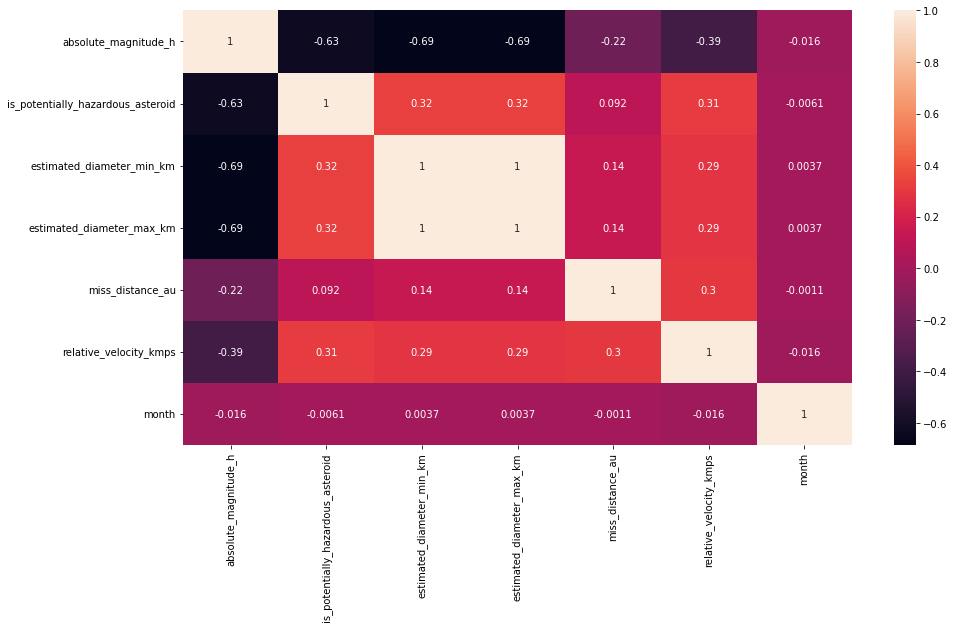

In [115]:
# correlation analysis
correlationanalysis = model_frame.corr()

# Resizing trick from matplotlib
plt.figure(figsize=(15,8))

# setting the annot argument to "True" to display labels
sns.heatmap(correlationanalysis,annot=True)

In [116]:
## including all previous columns, only dropping the dependent variable 'is_potentially_hazardous_asteroid'

X = model_frame[[
    'absolute_magnitude_h', 'estimated_diameter_min_km',
    'estimated_diameter_max_km', 'miss_distance_au', 'relative_velocity_kmps',
    'month'
]]

## Dep variable
# ensuring our y (prediction) is only included
y = model_frame['is_potentially_hazardous_asteroid']

In [117]:
#Creating Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

#Creating validation set
X_train, X2, y_train, y2 = train_test_split(X, y, test_size=0.2, random_state=30)

X_val, X_test, y_val, y_test = train_test_split(X2, y2, test_size=0.5, random_state=30)

# **Logistic Regression Model**

In [118]:
# initializing our logistic regression model, we set the maximum iterations to 3000 so that the model can find a solution. The default may be sufficient in most cases (100)
lr = LogisticRegression(random_state=7007, max_iter=3000)
lr.fit(X_train, y_train)

# using our model to predict
y_pred = lr.predict(X_test)

# evaluation
print("Accuracy Score:",accuracy_score(y_test, y_pred))

Accuracy Score: 0.8376664552948636


In [119]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.76      0.82       779
        True       0.80      0.91      0.85       798

    accuracy                           0.84      1577
   macro avg       0.85      0.84      0.84      1577
weighted avg       0.85      0.84      0.84      1577



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

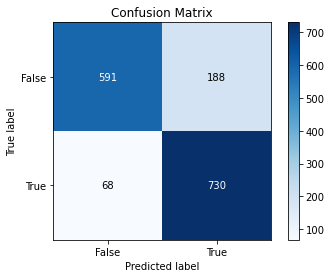

In [120]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [121]:
#Validation Set testing
lr = LogisticRegression(random_state=7007, max_iter=3000)
lr.fit(X_train, y_train)

# using our model to predict
y_pred = lr.predict(X_val)

# evaluation
print("Accuracy Score:",accuracy_score(y_val, y_pred))

Accuracy Score: 0.8458121827411168


# **Decesion Tree**

In [122]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test, y_pred))


Accuracy Score: 0.8065948002536462


## **SVM Model**

In [123]:
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print("Accuracy Score : ", accuracy_score(y_test,y_pred))

Accuracy Score :  0.8528852251109702


In [124]:
#Validation
svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_val)
print("Accuracy Score : ", accuracy_score(y_val,y_pred))

Accuracy Score :  0.8540609137055838


# **Model 4: kNN**

In [125]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy Score : ", accuracy_score(y_test,y_pred))

Accuracy Score :  0.8332276474318326


# **Model 5: random forest**

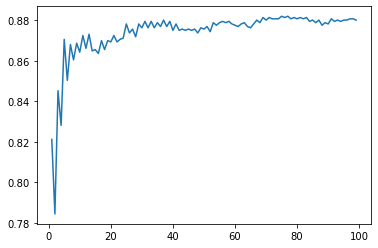

In [126]:
# the range of trees we want to test
numberoftrees = range(1, 100)
scores = []

# for loop
for n in numberoftrees:
    # in the n_estimators parameter, we're going to be testing all the values found in our range
    rf = RandomForestClassifier(n_estimators=n, random_state=1337)
    # fitting our model
    rf.fit(X_train, y_train)
    #prediction
    y_pred = rf.predict(X_test)
    # appending our result to variable scores
    scores.append(accuracy_score(y_test, y_pred))

# plotting our results
plt.plot(numberoftrees, scores)

In [127]:
# initializing our random forest model
rf = RandomForestClassifier(n_estimators=70)
rf.fit(X_train, y_train)

# using our model to predict
y_pred = rf.predict(X_test)

# accuracy score
accuracy_score(y_test, y_pred)

0.87571337983513

In [128]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.80      0.86       779
        True       0.83      0.95      0.89       798

    accuracy                           0.88      1577
   macro avg       0.89      0.87      0.87      1577
weighted avg       0.88      0.88      0.87      1577



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

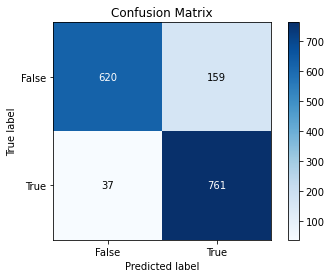

In [129]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [133]:
rf = RandomForestClassifier(n_estimators=70, random_state=110)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(accuracy_score(y_val, y_pred))

0.868020304568528


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

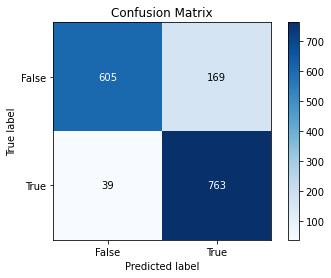

In [134]:
skplt.metrics.plot_confusion_matrix(y_val, y_pred)

In [135]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_val, y_pred)

0.8665126589211725

<AxesSubplot:title={'center':'Feature Importance'}>

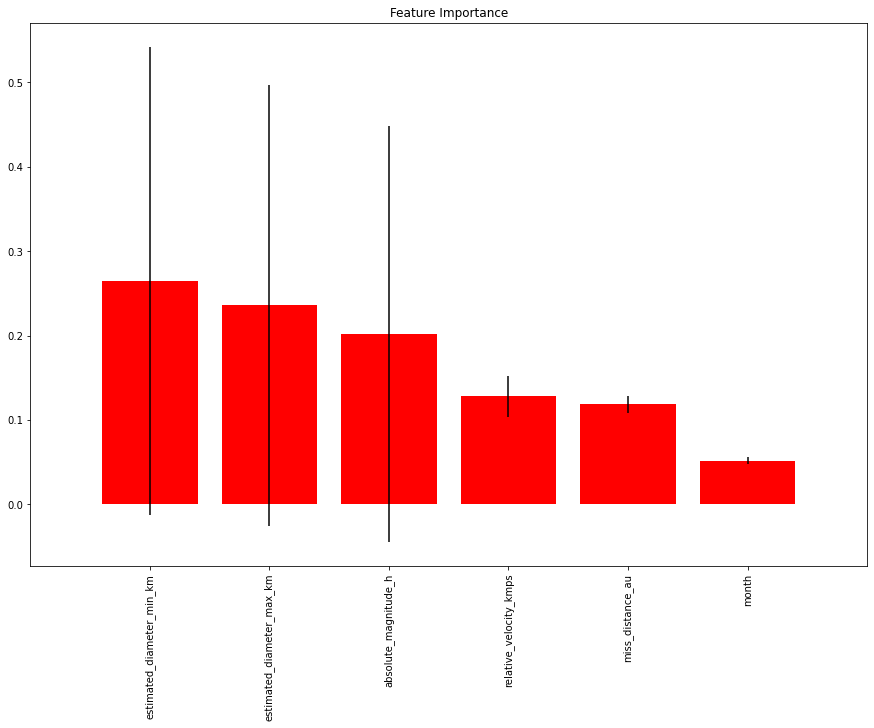

In [136]:
# assigning column names to variable 'feature_names'
feature_names = X.columns

skplt.estimators.plot_feature_importances(rf, feature_names=feature_names, figsize=(15, 10), x_tick_rotation=90)